# Vegetation Phenology <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on phenology](https://www.usgs.gov/land-resources/eros/phenology).

## Description

This notebook calculates vegetation phenology changes using Landsat 8 data.
To detect changes in plant life for Landsat, the algorithm uses either the `Normalized Difference Vegetation Index (NDVI)` or the `Enhanced Vegetation Index (EVI)`, which are common proxies for vegetation growth and health.
The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.
This notebook demonstrates the following steps:

1. Load cloud-masked Landsat-8 data for an area of interest.
2. Calculate the vegetation proxy index (NDVI or EVI).
3. Generate a time series boxplot for the chosen index over all years.
4. Generate a time series of the mean index for each year.
5. Calculate phenology statistics, such as beginning and end of season for each year. 

There are two output products for this notebook:

* The first output product is a time series boxplot of NDVI or EVI with the data potentially binned by week, month, week of year, or month of year. 
* The second output product is a time series lineplot of the mean NDVI or EVI for each year, with the data potentially binned by week or month. This product is useful for comparing years to each other.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
import datetime as dt
import os

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map

from plotter_utils import xarray_time_series_plot
from phenology import TIMESAT_stats

import warnings
warnings.filterwarnings("ignore", "Mean of empty slice")
warnings.simplefilter("ignore", FutureWarning)

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Vegetation_phenology')

### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `NDVI` or `EVI`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `years_range`: The year range to analyse (e.g. `('2013', '2018')`).



In [3]:
# Set the vegetation proxy to use
veg_proxy = 'NDVI'

# Define area of interest: Aviv Coffee Farm, Tanzania
lat = -10.6976
lon = 35.2686
lon_buffer = 0.00200
lat_buffer = 0.00190

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Set the range of dates for the analysis
years_range = ('2013', '2018')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load cloud-masked Landsat data

The first step is to load Landsat 8 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

In [5]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': years_range,
    'measurements': ['red', 'blue', 'nir'],
    'resolution': (-30,30),
}

# Identify the most common projection system in the input query 
crs = mostcommon_crs(dc=dc,
                     product='ls8_usgs_sr_scene',
                     query=query
                    )

# Load available data from Landsat 8
dataset = load_ard(dc=dc,
                   products=['ls8_usgs_sr_scene'],
                   output_crs=crs,
                   **query
                  )

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Loading 221 time steps


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [6]:
dataset

<xarray.Dataset>
Dimensions:      (time: 221, x: 16, y: 15)
Coordinates:
  * time         (time) datetime64[ns] 2013-04-21T07:47:21.977564 ... 2018-12-31T07:45:27.105157
  * x            (x) float64 7.479e+05 7.479e+05 ... 7.483e+05 7.484e+05
  * y            (y) float64 -1.183e+06 -1.183e+06 ... -1.184e+06 -1.184e+06
    spatial_ref  int32 0
Data variables:
    red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref

## Compute band indices

This study measures the presence of vegetation through either the `normalised difference vegetation index (NDVI)` or the `enhanced vegetation index (EVI)`.
The index that will be used is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The normalised difference vegetation index (NDVI) requires the `red` and `nir` (near-infra red) bands. 
The formula is

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

The Enhanced Vegetation Index requires the `red`, `nir` and `blue` bands.
The formula is

$$
\begin{aligned}
\text{EVI} & = \frac{2.5 \times (\text{NIR} - \text{Red})}{(\text{NIR} + 6 \times \text{Red} - 7.5 \times \text{Blue} + 1)} \\
\end{aligned}
$$


Both indices are available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_bandindices.py](../Scripts/deafrica_bandindices.py).
Here, we use `collection='c1'` since we're working with Landsat Collection-1 data.

In [7]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
dataset = calculate_indices(dataset, index=veg_proxy, collection='c1')

The vegetation proxy index should now appear as a data variable, along with the loaded measurements, in the `dataset` object.
Check this by printing the data set below:

In [8]:
dataset

<xarray.Dataset>
Dimensions:      (time: 221, x: 16, y: 15)
Coordinates:
  * time         (time) datetime64[ns] 2013-04-21T07:47:21.977564 ... 2018-12-31T07:45:27.105157
  * x            (x) float64 7.479e+05 7.479e+05 ... 7.483e+05 7.484e+05
  * y            (y) float64 -1.183e+06 -1.183e+06 ... -1.184e+06 -1.184e+06
    spatial_ref  int32 0
Data variables:
    red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    NDVI         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref

## Create phenology products

In this section, two plots are generated that can be used to investigate variability in seasonal growth over the chosen time-period.

### Box-and-Whisker Plot

This plot shows the median, minimum, maximum and inter-quartile range of the chosen vegetation proxy index as a function of time. 
The statistics are calculated for the whole area of interest, and binned by time. 
The length of time to bin by can be changed below, along with a number of parameters to customise the plot:

* `plot_curve_fit`: Specify whether to plot a curve fit of the vegetation index along time, either `True` or `False`.
* `curve_fit_target`: Specify the target aggregation type of the curve fit, either `'mean'` or `'median'`
* `max_times_per_plot`: Set the maximum number of data points that appear along time in each plot. If more than this number of data points need to be plotted, a grid of plots will be created.
* `bin_by`: Select the binning approach for the vegetation index:
  *  `None` do not bin the data
  * `'week'` bin the data by week with an extended time axis
  * `'month'` bin the data by month with an extended time axis
  * `'weekofyear'` bin the data by week and years using a single year time axis
  * `'monthofyear'` bin the data by month and years using a single year time axis
  
Edit and run the next cell to set the chosen options for the box-and-whisker plot:

In [9]:
# Set whether to plot a curve fit to the box-and-whisker plot
# and type of curve
plot_curve_fit = True
curve_fit_target = 'median'

# Set maximum number of data points for the time axis of the plot
max_times_per_plot = 40 

# Set the length of time to bin by
bin_by = 'monthofyear'

#### Generate the plot
Run the following cell to generate the plot.
Depending on the choice of `bin_by`, the data will be resampled or grouped before the statistics are calculated and plotted.

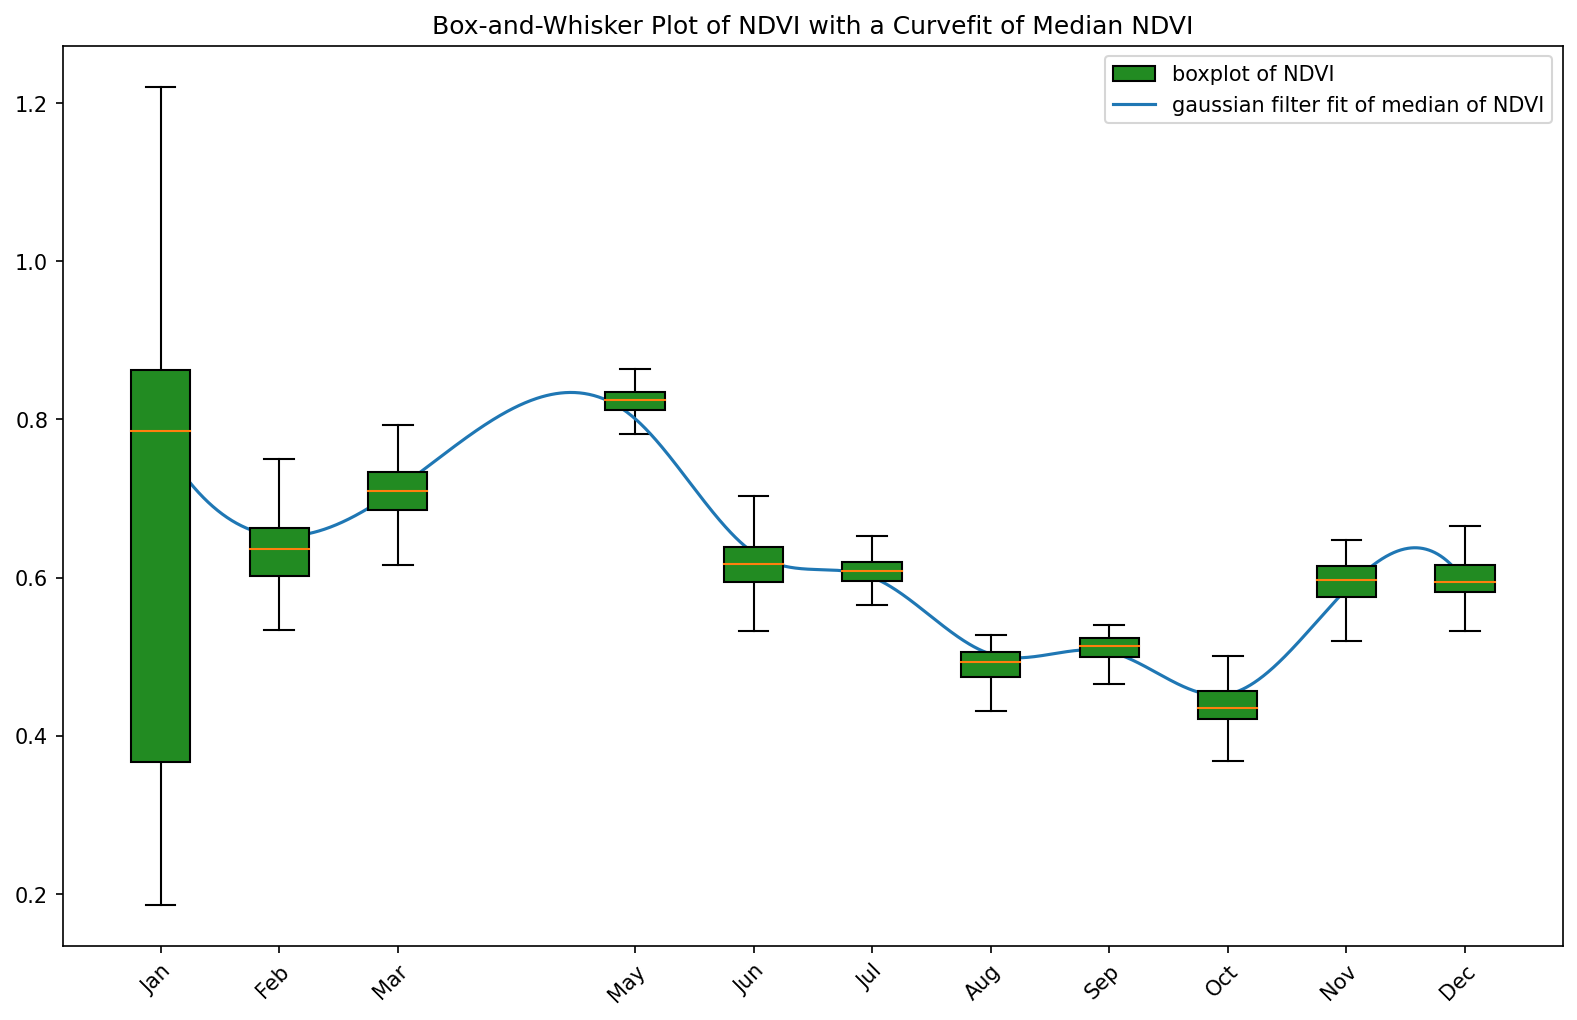

In [10]:
# Determine binning method
aggregated_by_str = None
if bin_by is None:
    plotting_data = dataset
elif bin_by == 'week':
    plotting_data = dataset.resample(time='1w').mean(skipna=True)
    aggregated_by_str = 'Week'
elif bin_by == 'month':
    plotting_data = dataset.resample(time='1m').mean(skipna=True)
    aggregated_by_str = 'Month'
elif bin_by == 'weekofyear':
    plotting_data = dataset.groupby('time.week').mean(dim=('time'), skipna=True)
    aggregated_by_str = 'Week of Year'
elif bin_by == 'monthofyear':
    plotting_data = dataset.groupby('time.month').mean(dim=('time'), skipna=True)
    aggregated_by_str = 'Month of Year'
else:
    assert bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear'], \
        "The variable 'bin_by' can only have one of these values: "\
        "[None, 'week', 'month', 'weekofyear', 'monthofyear']"

# Customise the plot appearance
plot_descs = {veg_proxy: {'none': [{'box': {'boxprops': {'facecolor':'forestgreen'}}}]}}
if plot_curve_fit:
    plot_descs[veg_proxy][curve_fit_target] = [{'gaussian_filter':{}}]

# Generate the box-and-whisker plot
xarray_time_series_plot(
    dataset=plotting_data,
    plot_descs=plot_descs,
    x_coord='x', y_coord='y',
    fig_params=dict(figsize=(10,6), dpi=150),
    max_times_per_plot=max_times_per_plot
)
plt.title(f'Box-and-Whisker Plot of {veg_proxy} with a Curvefit of Median {veg_proxy}')
plt.show()

### Plot the Vegetation Index Over Time for Each Year

To get an idea of how the growth varies from year to year, this plot shows a Guassian filter fit to the mean value of the vegetation proxy index for chosen time-bins. To allow the years to be easily compared, there are two choices for the binning, again set using the `bin_by` parameter: 
* `'weekofyear'` bin the data by week and years using a single year time axis
* `'monthofyear'` bin the data by month and years using a single year time axis

Edit and run the next cell to set the time to bin by for the summary plot:

In [11]:
bin_by = 'monthofyear'

#### Generate the plot
Run the following cell to generate the plot.

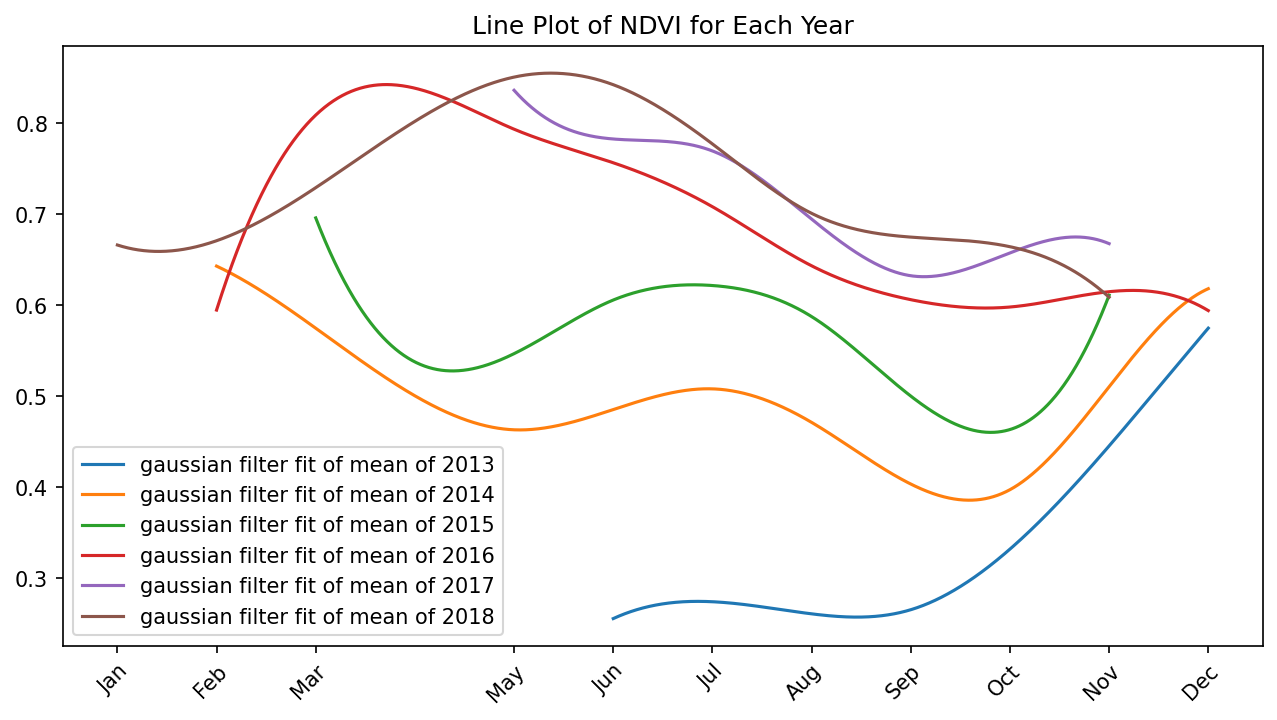

In [12]:
# Set up lists and dictionaries to store information
years_with_data = []
plot_descs = {}
daysofyear_per_year = {}
plotting_data_years = {}
time_dim_name = None

# Loop over each year and calculate the curves for the plot
for year in np.unique(dataset.time.dt.year):
    year_data = dataset.sel(time=str(year))[veg_proxy]
    if len(year_data['time']) == 0: # There is nothing to plot for this year.
        print("Year {} has no data, so will not be plotted.".format(year))
        continue
    years_with_data.append(year)
    
    spec_ind_dayofyear = year_data.groupby('time.dayofyear').mean()
    daysofyear_per_year[year] = spec_ind_dayofyear.where(~spec_ind_dayofyear.isnull()).dayofyear

    aggregated_by_str = None
    if bin_by == 'weekofyear':
        plotting_data_year = year_data.groupby('time.week').mean(dim=('time'))
        time_dim_name = 'week'
    elif bin_by == 'monthofyear':
        plotting_data_year = year_data.groupby('time.month').mean(dim=('time'))
        time_dim_name = 'month'
    else:
        assert bin_by in ['weekofyear', 'monthofyear'], \
            "The variable 'bin_by' can only have one of these values: "\
            "['weekofyear', 'monthofyear']"            

    plotting_data_years[year] = plotting_data_year  
    plot_descs[year] = {'mean':[{'gaussian_filter':{}}]}

# Collate all plotting data after the loop
plotting_data = xr.merge([{k:v} for k,v in plotting_data_years.items()])

# Generate the yearly summary plot
fig, curve_fit_plotting_data = xarray_time_series_plot(
    dataset=plotting_data, 
    plot_descs=plot_descs, 
    x_coord='x', y_coord='y',
    fig_params=dict(figsize=(8,4), dpi=150)
)
plt.title(f'Line Plot of {veg_proxy} for Each Year')
plt.show()

### Export Curve Fits to a CSV File

After generating the curve fits, it can be useful to export them to a csv file for later use. 
The next cell starts by converting the curve fits to a `pandas.Dataframe`, then converts months stored as floats into easy-to-use integers.
Finally, the dataframe is exported as a csv.

In [13]:
# Convert the data to a `pandas.DataFrame`.
dataarrays = []
for (year, _, _), dataarray in curve_fit_plotting_data.items():
    dataarrays.append(dataarray.rename(year))
curve_fit_df = xr.merge(dataarrays).to_dataframe()

# Convert the month floats to day ints and average by day (scale to [0,1], multiply by 364, add 1).
curve_fit_df.index.values[:] = (364/11) * (curve_fit_df.index.values - 1) + 1
curve_fit_df.index = curve_fit_df.index.astype(int)
curve_fit_df.index.name = 'day of year'
curve_fit_df = curve_fit_df.groupby('day of year').mean()

# Export the data to a CSV.
csv_output_dir = 'output/CSVs/'
if not os.path.exists(csv_output_dir):
    os.makedirs(csv_output_dir)
curve_fit_df.to_csv(csv_output_dir + 'vegetation_phenology_yearly_curve_fits_landsat.csv')

### Show [TIMESAT](http://web.nateko.lu.se/timesat/timesat.asp) Stats

[TIMESAT](http://web.nateko.lu.se/timesat/timesat.asp) is a software package for analysing time-series of satellite data.
It was developed for estimating growing seasons and computing phenological metrics.
This section uses a reproduction of the functionality designed for Python.

The length of time to bin by can be changed below, along with a number of parameters to customise the plot:

The minimum number of weeks or months with data for a year to have its stats calculated can be changed below through two parameters:
* `min_weeks_per_year`: The minimum number of weeks of data needed to process a year for weekly data, eg `40`.
* `min_months_per_year`: The minimum number of months of data needed to process a year for monthly data, eg `9`.

The `bin_by` aggregation that is used to obtain the plotting data determines the time scale to bin on, and which to the two minimum functions to apply.

Edit and run the next cell to set the minimum number of weeks or months required to calculate statistics:

In [19]:
min_weeks_per_year = 40
min_months_per_year = 9

#### Calculate statistics
Run the following cell to calculate and output the TIMESAT statistics.

In [20]:
# Loop over each year to calculate the statistics per year
for year, dataarray in plotting_data_years.items():
    dataarray = dataarray.mean(['x', 'y']).dropna(dim=time_dim_name)
    num_times = dataarray.sizes[time_dim_name]
    print()
    
    if bin_by == 'weekofyear':
        if num_times < min_weeks_per_year:
            print(f"There are {num_times} weeks with data for {year}, but the minimum number of weeks is {min_weeks_per_year}.")
            continue
    elif bin_by == 'monthofyear':
        if num_times < min_months_per_year:
            print(f"There are {num_times} months with data for {year}, but the minimum number of months is {min_months_per_year}.")
            continue
            
    stats = TIMESAT_stats(dataarray, time_dim=time_dim_name)
    
    # Map indices to days of the year (can't use data from `daysofyear_per_year` directly
    # because `xarray_time_series_plot()` can have more points for smooth curve fitting.
    time_int_arr = dataarray[time_dim_name].values
    orig_day_int_arr = daysofyear_per_year[year].values
    day_int_arr = np.interp(time_int_arr, 
                            (time_int_arr.min(), time_int_arr.max()), 
                            (orig_day_int_arr.min(), orig_day_int_arr.max())
                           )
    
    # Convert "times" in the TIMESAT stats from indices to days (ints).
    stats['Beginning of Season'] = int(round(day_int_arr[stats['Beginning of Season']]))
    stats['Middle of Season'] = int(round(day_int_arr[stats['Middle of Season']]))
    stats['End of Season'] = int(round(day_int_arr[stats['End of Season']]))
    stats['Length of Season'] = np.abs(stats['End of Season'] - stats['Beginning of Season']) 
    
    # For each year, print the key output statistics
    print("Year =", year)
    print("Beginning of Season (BOS) day =", stats['Beginning of Season'])
    print("End of Season (EOS) day =", stats['End of Season'])
    print("Middle of Season (MOS) day =", stats['Middle of Season'])
    print("Length of Season (abs(EOS-BOS)) in days =", stats['Length of Season'])
    print("Base Value (Min) =", stats['Base Value'])
    print("Max Value (Max) =", stats['Max Value'])
    print("Amplitude (Max-Min) =", stats['Amplitude'])


There are 6 months with data for 2013, but the minimum number of months is 9.

There are 8 months with data for 2014, but the minimum number of months is 9.

There are 7 months with data for 2015, but the minimum number of months is 9.

Year = 2016
Beginning of Season (BOS) day = 8
End of Season (EOS) day = 290
Middle of Season (MOS) day = 43
Length of Season (abs(EOS-BOS)) in days = 282
Base Value (Min) = 0.59255564
Max Value (Max) = 0.81171554
Amplitude (Max-Min) = 0.2191599

There are 6 months with data for 2017, but the minimum number of months is 9.

There are 8 months with data for 2018, but the minimum number of months is 9.


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.0b7.dev35+g5023dada


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)